In [23]:
# add explainn subfolder to os path
import sys
sys.path.append('..')
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
import json
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sys.path.append('../scripts')
from utils import (get_file_handle, get_seqs_labels_ids, get_data_loader,
                   get_device)

Load a model

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir = "../../SCRATCH/AS-TAC/ExplaiNN/single_train/num_cnns_100_14485214"
model_dir_list = os.listdir(model_dir)

In [34]:
import pandas as pd


# Load the JSON file
with open(model_dir + '/parameters-train.py.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary into a DataFrame
df = pd.DataFrame([data])

# find the .pth file in weight_file list
for file in model_dir_list:
    if file.endswith(".pth"):
        weight_file = file
        break
#print(100)

In [36]:
handle=get_file_handle(model_dir + '/parameters-train.py.json', "rt")
train_args = json.load(handle)
handle.close()
# if "training_file" in train_args: # i.e. for fine-tuned models
#     handle = get_file_handle(train_args["training_file"], "rt")
#     train_args = json.load(handle)
#     handle.close()

In [37]:
train_args

{'batch_size': 100,
 'checkpoint': 0,
 'cpu_threads': 1,
 'criterion': 'BCEWithLogits',
 'debugging': False,
 'filter_size': 19,
 'input_length': 1000,
 'lr': 0.005,
 'num_epochs': 200,
 'num_fc': 2,
 'num_units': 100,
 'optimizer': 'Adam',
 'output_dir': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/ExplaiNN/single_train/100_units_14485214',
 'patience': 10,
 'pool_size': 7,
 'pool_stride': 7,
 'rev_complement': False,
 'time': False,
 'training_file': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/AS-TAC_21_25_train.tsv',
 'trim_weights': False,
 'validation_file': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/AS-TAC_21_25_test.tsv'}

In [28]:
num_cnns = df.iloc[0]['num_units']
input_length = df.iloc[0]['input_length']
num_classes = 63
filter_size = df.iloc[0]['filter_size']

explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
explainn.load_state_dict(torch.load(model_dir + "/" + weight_file, map_location=torch.device('cpu')))
explainn.eval();

In [29]:
networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size, num_fc=1).to(device)
#explainn

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(14000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=63, bias=True)
)

In [30]:
weights = explainn.final.weight.detach().cpu().numpy()

In [41]:
    # load target_labels
with open("../../SCRATCH//AS-TAC/bed_list_test", 'r') as f:
    target_labels = f.read().splitlines()

# Remove "AS-TAC-peaks/AtlanticSalmon_ATAC_" and ".mLb.clN_peaks.narrowPeak" from the strings in labels list
target_labels = [target_labels.replace("AS-TAC-peaks/AtlanticSalmon_ATAC_", "").replace(".mLb.clN_peaks.narrowPeak", "") for label in target_labels]


IndentationError: expected an indented block after 'with' statement on line 2 (1611884864.py, line 3)

In [38]:
df = raw_prcs_explainn.reset_index()
df['tissue'] = df['index'].str.split('_').str[0]

NameError: name 'raw_prcs_explainn' is not defined

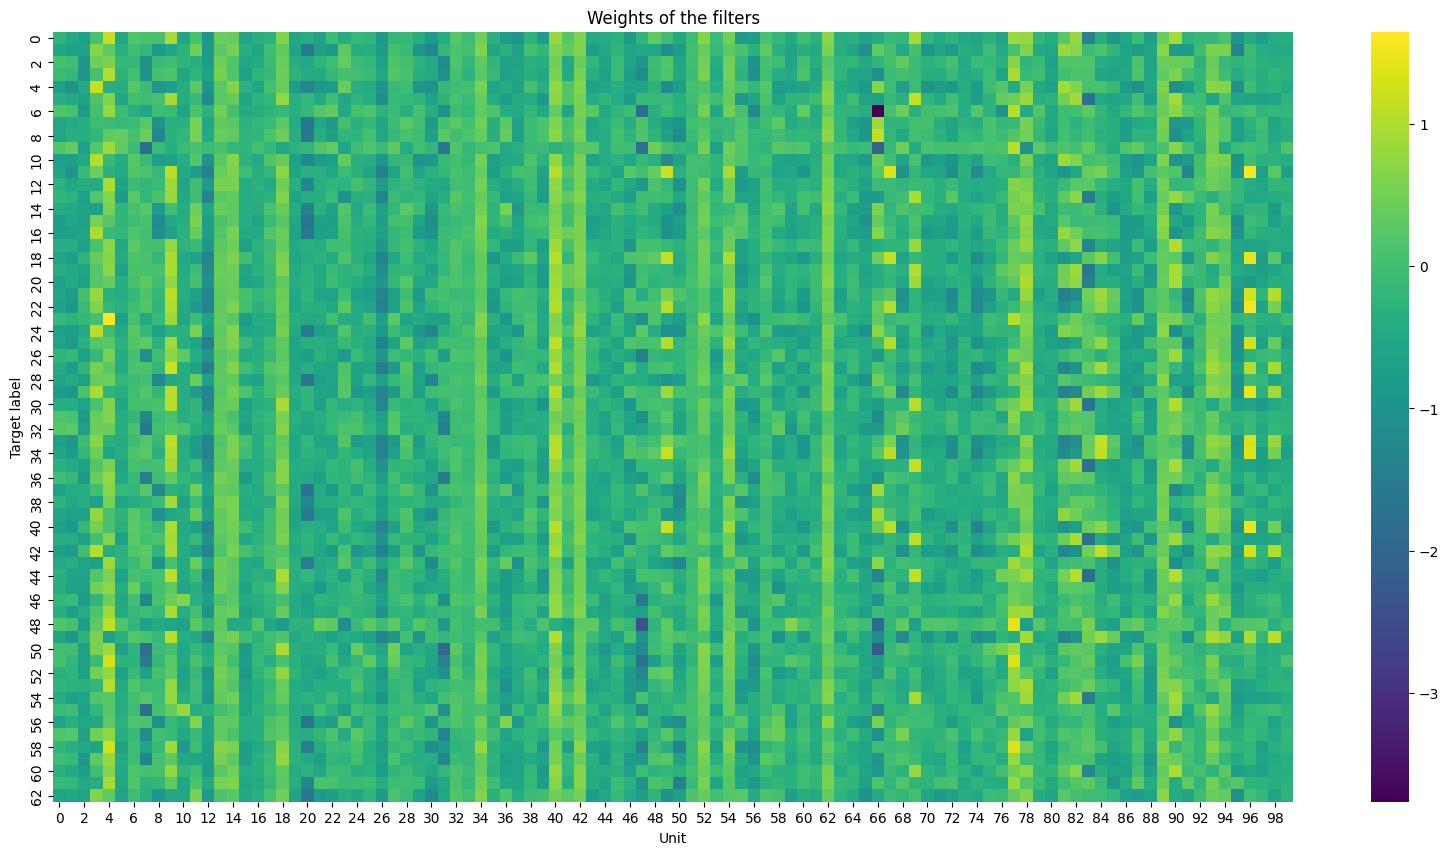

In [32]:
# make a heatmap of weights, y axis is the filter number, x axis is the position in the filter
weights = explainn.final.weight.detach().cpu().numpy()
plt.figure(figsize=(20,10))
sns.heatmap(weights, cmap="viridis")
plt.ylabel("Target label")
plt.xlabel("Unit")

plt.title("Weights of the filters")
plt.savefig(model_dir + "/weights.png")
